In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
train_df = pd.read_csv('../data/ex_train.csv')
val_df = pd.read_csv('../data/ex_val.csv')
test_df = pd.read_csv('../data/ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(13239, 12) (3783, 12) (1892, 12)


In [5]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [6]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Chapter 13 

## Single-step
### Baseline

In [7]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2'])

In [8]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [9]:
baseline_last = Baseline(label_index=column_indices['NO2'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [10]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

119/119 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0287


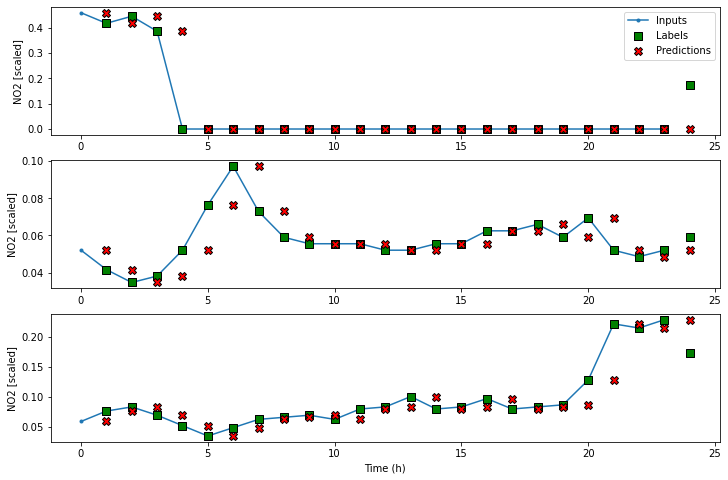

In [11]:
wide_window.plot(baseline_last)

## Multi-step
### Baseline

#### Repeast last value 

In [12]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['NO2'])

In [13]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [14]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['NO2'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 0s 595us/step - loss: 0.1443 - mean_absolute_error: 0.2821


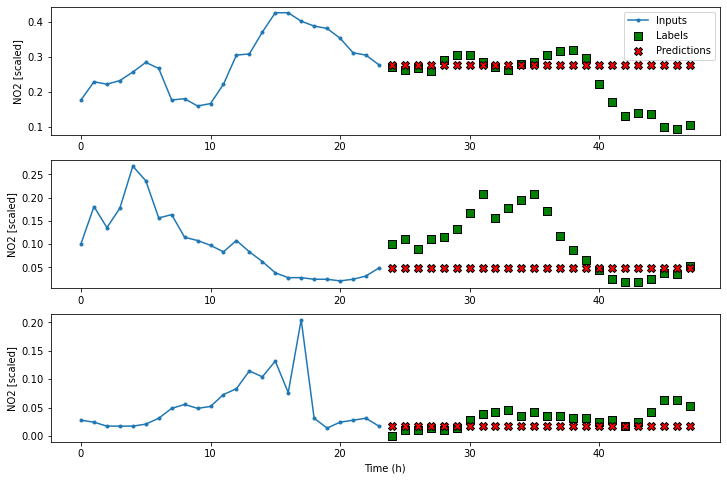

In [15]:
multi_window.plot(ms_baseline_last)

#### Repeat last season 

In [16]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [17]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['NO2'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 0s 569us/step - loss: 0.1426 - mean_absolute_error: 0.2818


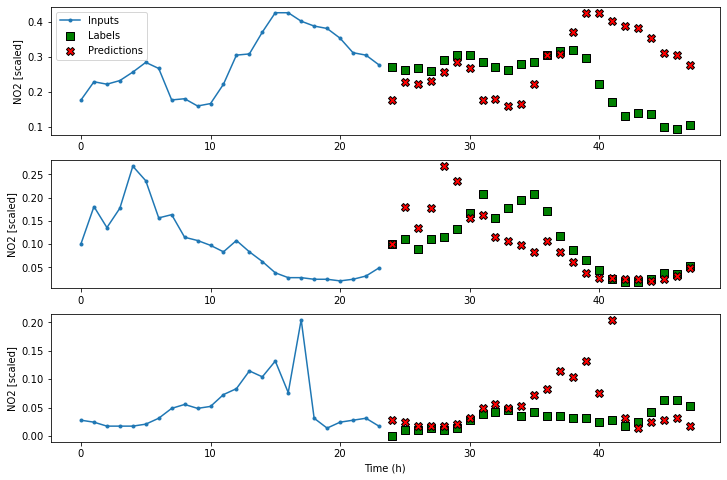

In [18]:
multi_window.plot(ms_baseline_repeat)

## Multi-output
### Baseline

In [19]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2','TEMP']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2','TEMP'])

In [20]:
print(column_indices['NO2'])
print(column_indices['TEMP'])

3
6


In [21]:
mo_baseline_last = Baseline(label_index=[3, 6])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

118/118 [==============================] - 0s 581us/step - loss: 0.0013 - mean_absolute_error: 0.0215


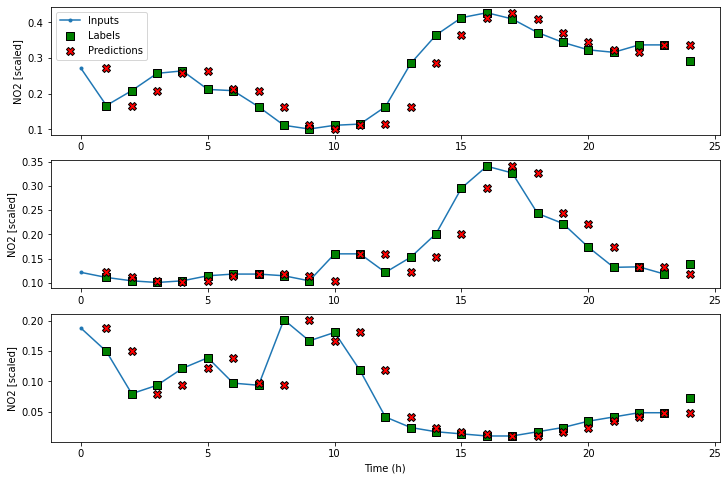

In [22]:
mo_wide_window.plot(mo_baseline_last)

# Chapter 14 

In [23]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

## Single-step 

### Linear model 

In [24]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 1s 1ms/step - loss: 0.0355 - mean_absolute_error: 0.1457 - val_loss: 0.0091 - val_mean_absolute_error: 0.0745
Epoch 2/50
414/414 [==============================] - 0s 814us/step - loss: 0.0080 - mean_absolute_error: 0.0689 - val_loss: 0.0046 - val_mean_absolute_error: 0.0526
Epoch 3/50
414/414 [==============================] - 0s 785us/step - loss: 0.0051 - mean_absolute_error: 0.0544 - val_loss: 0.0035 - val_mean_absolute_error: 0.0454
Epoch 4/50
414/414 [==============================] - 0s 792us/step - loss: 0.0039 - mean_absolute_error: 0.0471 - val_loss: 0.0030 - val_mean_absolute_error: 0.0413
Epoch 5/50
414/414 [==============================] - 0s 785us/step - loss: 0.0031 - mean_absolute_error: 0.0414 - val_loss: 0.0026 - val_mean_absolute_error: 0.0370
Epoch 6/50
414/414 [==============================] - 0s 782us/step - loss: 0.0025 - mean_absolute_error: 0.0371 - val_loss: 0.0023 - val_mean_absolute_error: 0.0340
Epoch 

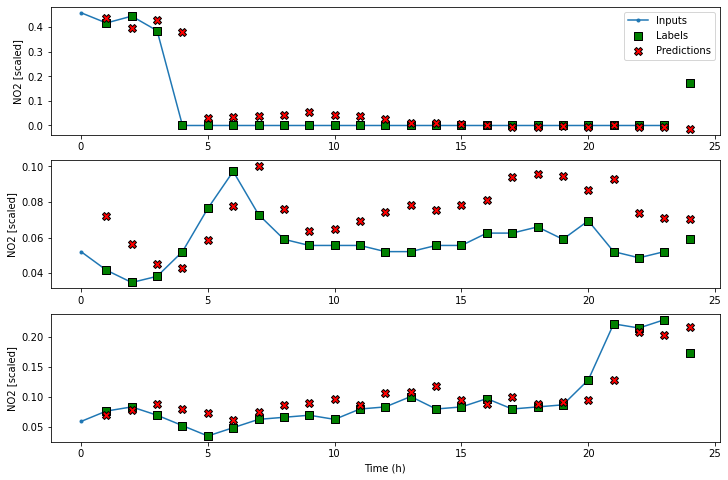

In [25]:
wide_window.plot(linear)

### Dense model (DNN) 

In [26]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 2s 1ms/step - loss: 0.0028 - mean_absolute_error: 0.0361 - val_loss: 0.0021 - val_mean_absolute_error: 0.0303
Epoch 2/50
414/414 [==============================] - 0s 981us/step - loss: 0.0016 - mean_absolute_error: 0.0275 - val_loss: 0.0021 - val_mean_absolute_error: 0.0309
Epoch 3/50
414/414 [==============================] - 0s 927us/step - loss: 0.0016 - mean_absolute_error: 0.0277 - val_loss: 0.0021 - val_mean_absolute_error: 0.0304
Epoch 4/50
414/414 [==============================] - 0s 932us/step - loss: 0.0016 - mean_absolute_error: 0.0267 - val_loss: 0.0020 - val_mean_absolute_error: 0.0291
Epoch 5/50
414/414 [==============================] - 0s 939us/step - loss: 0.0016 - mean_absolute_error: 0.0265 - val_loss: 0.0019 - val_mean_absolute_error: 0.0281
Epoch 6/50
414/414 [==============================] - 0s 918us/step - loss: 0.0016 - mean_absolute_error: 0.0268 - val_loss: 0.0020 - val_mean_absolute_error: 0.0287
Epoch 

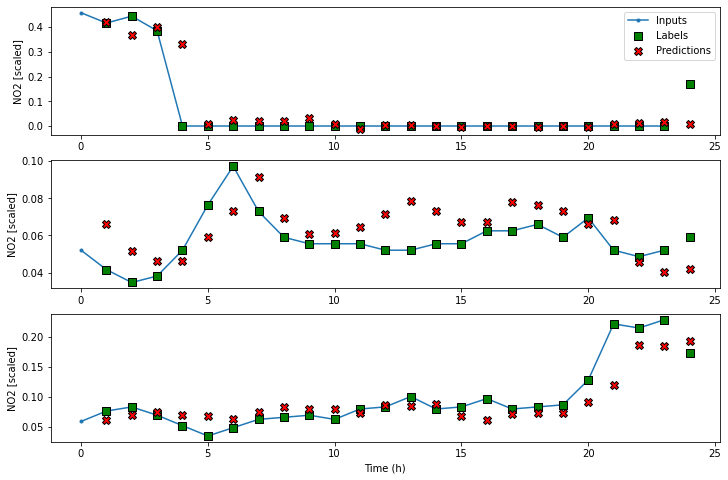

In [27]:
wide_window.plot(dense)

### Evaluation 

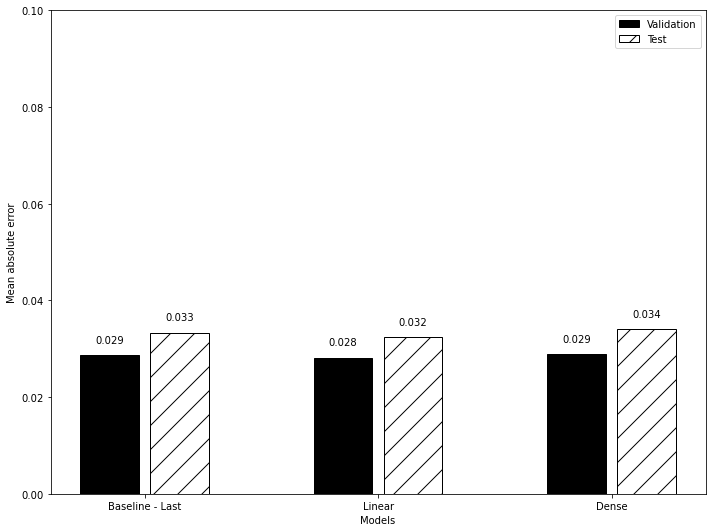

In [28]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

## Multi-step 

### Linear model 

In [29]:
label_index = column_indices['NO2']
num_features = train_df.shape[1]

ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0147 - mean_absolute_error: 0.0930 - val_loss: 0.0095 - val_mean_absolute_error: 0.0736
Epoch 2/50
413/413 [==============================] - 0s 833us/step - loss: 0.0123 - mean_absolute_error: 0.0847 - val_loss: 0.0091 - val_mean_absolute_error: 0.0717
Epoch 3/50
413/413 [==============================] - 0s 816us/step - loss: 0.0120 - mean_absolute_error: 0.0835 - val_loss: 0.0089 - val_mean_absolute_error: 0.0709
Epoch 4/50
413/413 [==============================] - 0s 799us/step - loss: 0.0118 - mean_absolute_error: 0.0827 - val_loss: 0.0088 - val_mean_absolute_error: 0.0703
Epoch 5/50
413/413 [==============================] - 0s 794us/step - loss: 0.0117 - mean_absolute_error: 0.0822 - val_loss: 0.0087 - val_mean_absolute_error: 0.0706
Epoch 6/50
413/413 [==============================] - 0s 799us/step - loss: 0.0116 - mean_absolute_error: 0.0819 - val_loss: 0.0088 - val_mean_absolute_error: 0.0701
Epoch 

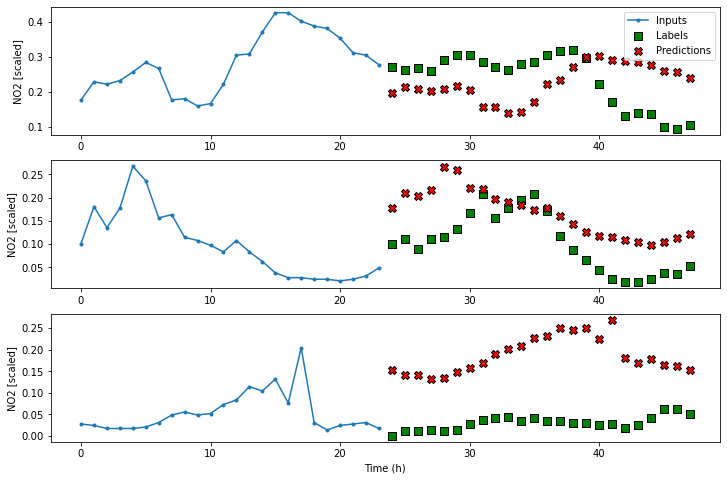

In [30]:
multi_window.plot(ms_linear)

### Dense model (DNN)

In [31]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 2s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0856 - val_loss: 0.0090 - val_mean_absolute_error: 0.0695
Epoch 2/50
413/413 [==============================] - 1s 1ms/step - loss: 0.0110 - mean_absolute_error: 0.0794 - val_loss: 0.0084 - val_mean_absolute_error: 0.0681
Epoch 3/50
413/413 [==============================] - 1s 1ms/step - loss: 0.0108 - mean_absolute_error: 0.0785 - val_loss: 0.0085 - val_mean_absolute_error: 0.0690
Epoch 4/50
413/413 [==============================] - 1s 1ms/step - loss: 0.0106 - mean_absolute_error: 0.0778 - val_loss: 0.0098 - val_mean_absolute_error: 0.0725
Epoch 5/50
117/117 [==============================] - 0s 759us/step - loss: 0.0094 - mean_absolute_error: 0.0709


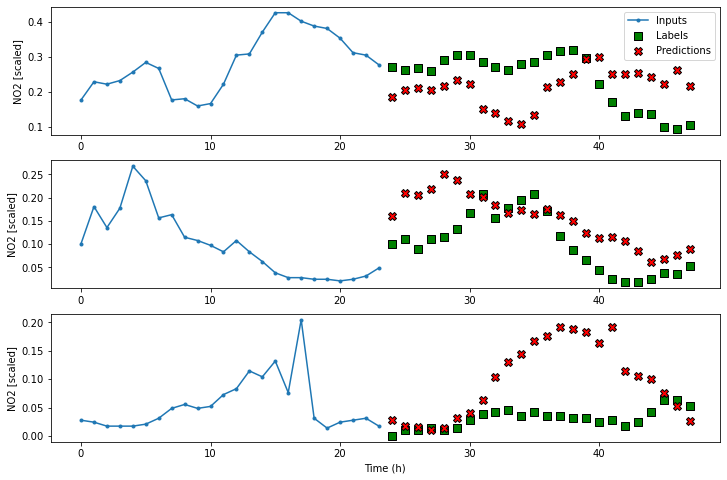

In [32]:
multi_window.plot(ms_dense)

### Evaluation

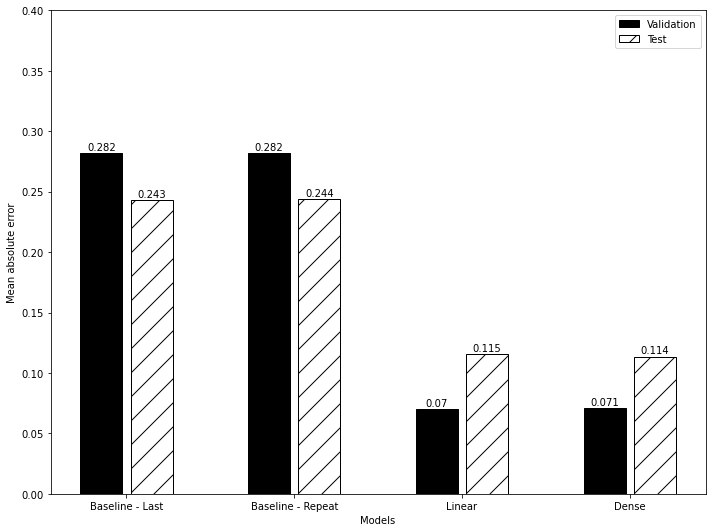

In [33]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

## Multi-output 

### Linear model 

In [34]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 1s 980us/step - loss: 0.0389 - mean_absolute_error: 0.1548 - val_loss: 0.0129 - val_mean_absolute_error: 0.0920
Epoch 2/50
414/414 [==============================] - 0s 809us/step - loss: 0.0088 - mean_absolute_error: 0.0737 - val_loss: 0.0052 - val_mean_absolute_error: 0.0558
Epoch 3/50
414/414 [==============================] - 0s 828us/step - loss: 0.0047 - mean_absolute_error: 0.0530 - val_loss: 0.0031 - val_mean_absolute_error: 0.0421
Epoch 4/50
414/414 [==============================] - 0s 804us/step - loss: 0.0033 - mean_absolute_error: 0.0440 - val_loss: 0.0023 - val_mean_absolute_error: 0.0347
Epoch 5/50
414/414 [==============================] - 0s 801us/step - loss: 0.0025 - mean_absolute_error: 0.0377 - val_loss: 0.0018 - val_mean_absolute_error: 0.0298
Epoch 6/50
414/414 [==============================] - 0s 809us/step - loss: 0.0020 - mean_absolute_error: 0.0331 - val_loss: 0.0015 - val_mean_absolute_error: 0.0267
Epoc

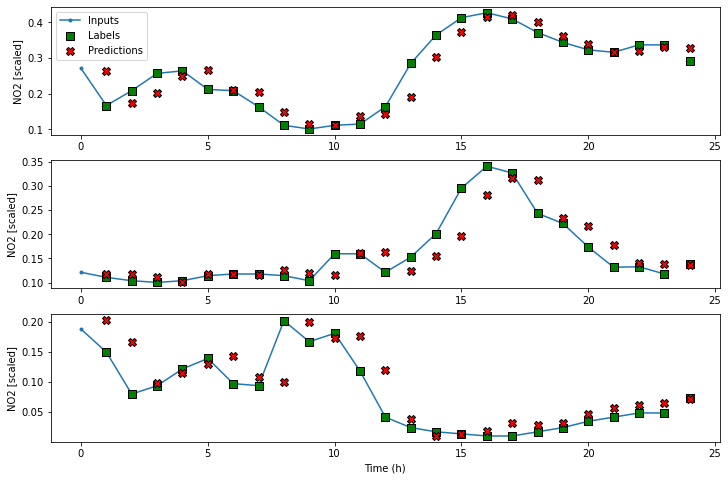

In [35]:
mo_wide_window.plot(mo_linear)

### Dense model (DNN) 

In [36]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0454 - val_loss: 0.0013 - val_mean_absolute_error: 0.0236
Epoch 2/50
414/414 [==============================] - 0s 956us/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 0.0013 - val_mean_absolute_error: 0.0225
Epoch 3/50
414/414 [==============================] - 0s 944us/step - loss: 9.8835e-04 - mean_absolute_error: 0.0201 - val_loss: 0.0012 - val_mean_absolute_error: 0.0223
Epoch 4/50
414/414 [==============================] - 0s 942us/step - loss: 9.8788e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0012 - val_mean_absolute_error: 0.0212
Epoch 5/50
414/414 [==============================] - 0s 935us/step - loss: 9.7886e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0012 - val_mean_absolute_error: 0.0214
Epoch 6/50
414/414 [==============================] - 0s 944us/step - loss: 9.9589e-04 - mean_absolute_error: 0.0203 - val_loss: 0.0013 - val_mean_absolute_erro

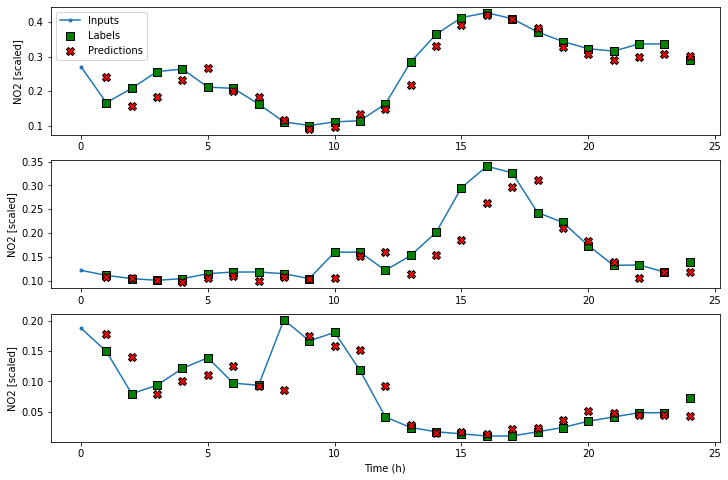

In [37]:
mo_wide_window.plot(mo_dense)

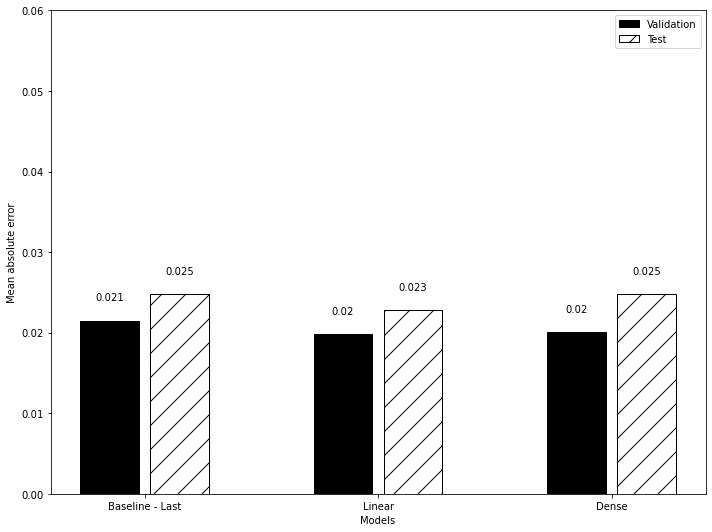

In [38]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()